In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import matplotlib.pyplot as plt
import numpy as np

In [15]:
from l2gx.patch.clustering.fennel import fennel_clustering
from l2gx.patch.clustering.rust_fennel import (
    fennel_clustering_rust, 
    is_rust_available
)
from l2gx.patch.clustering.metis import metis_clustering
from l2gx.graphs import TGraph
from l2gx.datasets import get_dataset
from scripts.test_graph_utils import generate_hidden_partition_model
from scripts.plot_test_graph import plot_graph_with_clusters, tgraph_to_networkx


# <font color="grey"> Graph Clustering</font>

In [4]:
num_nodes = 100
num_clusters = 10

In [5]:
tgraph, cluster_assignments = generate_hidden_partition_model(num_nodes=100, num_clusters=10, in_cluster_prob=0.8, out_cluster_prob=0.1)
print(f"Generated graph: {tgraph.num_nodes} nodes, {tgraph.num_edges} edges")


Generated graph: 100 nodes, 1652 edges


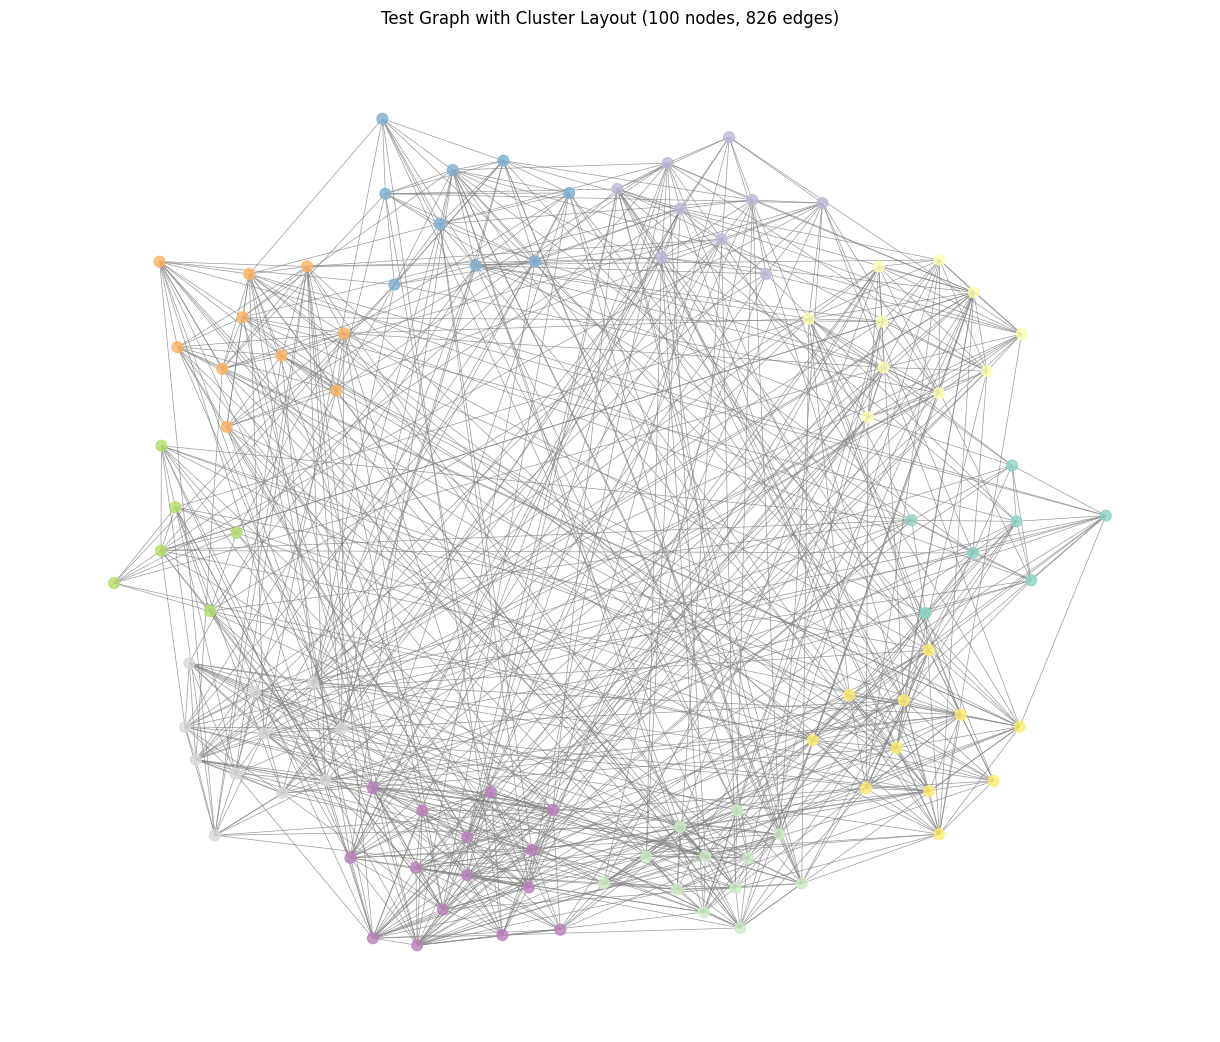

In [6]:
G = tgraph_to_networkx(tgraph)
fig = plot_graph_with_clusters(G, cluster_assignments)
plt.show()

In [7]:
edge_index_np = tgraph.edge_index.cpu().numpy()
adj_index_np = tgraph.adj_index.cpu().numpy()

In [8]:
adj_index_np

array([   0,   14,   25,   50,   64,   83,  102,  120,  135,  149,  167,
        188,  210,  229,  244,  254,  266,  281,  300,  308,  332,  346,
        361,  380,  395,  414,  428,  447,  458,  479,  490,  506,  516,
        532,  547,  567,  584,  603,  617,  633,  645,  662,  677,  697,
        719,  732,  751,  764,  777,  788,  803,  821,  836,  851,  866,
        890,  906,  920,  933,  946,  966,  985,  997, 1016, 1033, 1052,
       1073, 1087, 1113, 1133, 1150, 1169, 1188, 1202, 1219, 1236, 1254,
       1270, 1286, 1300, 1315, 1333, 1350, 1377, 1388, 1408, 1429, 1444,
       1455, 1474, 1491, 1508, 1518, 1531, 1546, 1562, 1581, 1599, 1614,
       1636, 1652])

In [10]:
edge_index_np

array([[ 0,  0,  0, ..., 99, 99, 99],
       [ 2,  4,  7, ..., 85, 86, 88]])

In [11]:
python_clusters = fennel_clustering_safe(
    edge_index_np,
    adj_index_np,
    tgraph.num_nodes,
    num_clusters,
    verbose=False
    )

Fennel iteration: 0, not converged: 100


In [12]:
python_clusters

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 6, 9, 0, 4, 8, 5, 7, 0, 1,
       4, 5, 2, 3, 6, 8, 7, 9, 0, 6, 2, 7, 4, 3, 1, 5, 9, 8, 1, 2, 0, 3,
       4, 5, 7, 1, 4, 6, 9, 8, 1, 2, 6, 5, 7, 8, 5, 4, 8, 0, 9, 9, 7, 3,
       1, 2, 7, 0, 3, 2, 7, 3, 6, 4, 0, 0, 8, 0, 5, 1, 2, 3, 6, 6, 9, 4,
       8, 6, 7, 9, 3, 5, 4, 5, 1, 4, 1, 2])

In [13]:
cluster_assignments

array([6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, 4, 1, 7, 5, 1, 4, 0,
       9, 5, 8, 0, 9, 2, 6, 3, 8, 2, 4, 2, 6, 4, 8, 6, 1, 3, 8, 1, 9, 8,
       9, 4, 1, 3, 6, 7, 2, 0, 3, 1, 7, 3, 1, 5, 5, 9, 3, 5, 1, 9, 1, 9,
       3, 7, 6, 8, 7, 4, 1, 4, 7, 9, 8, 8, 0, 8, 6, 8, 7, 0, 7, 7, 2, 0,
       7, 2, 2, 0, 4, 9, 6, 9, 8, 6, 8, 7])